# Example 8: Temporal UMAP with Tracked Cell Signals and Features

Cellular behavior can be classified based on similarities in features over time. In cytotoxicity studies, tracked cells provide rich multidimensional data, including measurements of cell shape, fluorescent signal intensity, kinematic features, and history of cell-cell contacts. A particularly challenging aspect is determining the origin of the death signal in a tracked cell, i.e., identifying which cell is delivering the signal. The process of stain uptake is intricate and often incapable of distinguishing between signaling cell types when multiple cells are involved.

In our research, we investigate cytotoxic events involving killer T cells (labeled with Cell Tracker Deep Red) and cancer cells (labeled with GFP), both of which express propidium iodide (PI) as a standard death marker. An essential strategy is to trace back the signal with a degree of tolerance for noise. Here, we showcase the application of the unsupervised learning method [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y) for visualizing, understanding, and exploring the time series of signals to uncover patterns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import umap
from tqdm import tqdm

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-08 11:54:32.158691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 11:54:34.675722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Single Cell Condition
For concept illustration, begin with single cell type

In [2]:
tracks_gfp_df = pd.read_csv("/mnt/Data/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/tracks/20231003_roi-5_0-2899_binT-1_cancer/tracks_remapped.csv")
tracks_gfp_df

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,1318.130348,0,CANCER,NaN,894,1000025,0.308649,910,919,219.029670
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,2169.971420,0,CANCER,NaN,895,1000028,0.609457,156,159,302.897436
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,1371.094849,0,CANCER,NaN,896,1000029,0.328590,50,51,181.500000
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,734.811983,0,CANCER,NaN,897,1000039,0.407693,291,291,153.859107
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,1617.135717,0,CANCER,NaN,900,1000040,0.222839,331,331,99.465257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,964.564149,2899,CANCER,NaN,49976,2900011772,2.789058,66,81,265.257576
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,284.310961,2899,CANCER,NaN,49979,2900014130,0.448188,63,81,113.333333
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,215.072645,2899,CANCER,NaN,49980,2900014124,11.110681,20,80,197.150000
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,1069.895284,2899,CANCER,NaN,49989,2900016071,0.294653,63,64,115.365079


In [3]:
tracks_pi_df = pd.read_csv("/mnt/Data/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/tracks/20231003_roi-5_0-2899_binT-1_cancer/tracks_pi_remapped.csv")
tracks_pi_df

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,2.638476,0,CANCER,NaN,894,1000025,0.308649,910,919,219.029670
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,13.639799,0,CANCER,NaN,895,1000028,0.609457,156,159,302.897436
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,2.964320,0,CANCER,NaN,896,1000029,0.328590,50,51,181.500000
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,2.680904,0,CANCER,NaN,897,1000039,0.407693,291,291,153.859107
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,3.453746,0,CANCER,NaN,900,1000040,0.222839,331,331,99.465257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,2.920804,2899,CANCER,NaN,49976,2900011772,2.789058,66,81,265.257576
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,2.704959,2899,CANCER,NaN,49979,2900014130,0.448188,63,81,113.333333
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,2.070935,2899,CANCER,NaN,49980,2900014124,11.110681,20,80,197.150000
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,6.469963,2899,CANCER,NaN,49989,2900016071,0.294653,63,64,115.365079


In [4]:
# merge the dfs
tracks_df = tracks_gfp_df.merge(tracks_pi_df[["mean","median","sd"]], how='outer', left_index=True, right_index=True, suffixes=("_gfp","_pi"))
tracks_df

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,mean_pi,median_pi,sd_pi
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,NaN,894,1000025,0.308649,910,919,219.029670,110.882114,113.144531,2.638476
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,NaN,895,1000028,0.609457,156,159,302.897436,119.688525,113.144531,13.639799
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,NaN,896,1000029,0.328590,50,51,181.500000,111.070312,113.144531,2.964320
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,NaN,897,1000039,0.407693,291,291,153.859107,110.484076,113.144531,2.680904
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,NaN,900,1000040,0.222839,331,331,99.465257,111.600000,113.144531,3.453746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,NaN,49976,2900011772,2.789058,66,81,265.257576,112.869231,133.328125,2.920804
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,NaN,49979,2900014130,0.448188,63,81,113.333333,112.547170,133.328125,2.704959
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,NaN,49980,2900014124,11.110681,20,80,197.150000,111.882353,133.328125,2.070935
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,NaN,49989,2900016071,0.294653,63,64,115.365079,120.943503,133.328125,6.469963


## Normalize Signal Intensity

In [5]:
tracks_df['mean_gfp_norm'] = (tracks_df['mean_gfp'] - tracks_df['mean_gfp'].mean()) / tracks_df['mean_gfp'].std()
tracks_df['mean_pi_norm'] = (tracks_df['mean_pi'] - tracks_df['mean_pi'].mean()) / tracks_df['mean_pi'].std()
tracks_df['median_gfp_norm'] = (tracks_df['median_gfp'] - tracks_df['median_gfp'].mean()) / tracks_df['median_gfp'].std()
tracks_df['median_pi_norm'] = (tracks_df['median_pi'] - tracks_df['median_pi'].mean()) / tracks_df['median_pi'].std()
tracks_df

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,tracked frames,tracked length,mean tracked cell size,mean_pi,median_pi,sd_pi,mean_gfp_norm,mean_pi_norm,median_gfp_norm,median_pi_norm
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,910,919,219.029670,110.882114,113.144531,2.638476,0.285864,-0.187057,0.731799,-0.320914
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,156,159,302.897436,119.688525,113.144531,13.639799,1.058180,-0.090278,1.082366,-0.320914
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,50,51,181.500000,111.070312,113.144531,2.964320,1.083503,-0.184989,1.362820,-0.320914
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,291,291,153.859107,110.484076,113.144531,2.680904,-0.962234,-0.191431,-0.880810,-0.320914
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,331,331,99.465257,111.600000,113.144531,3.453746,0.354197,-0.179168,0.311118,-0.320914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,66,81,265.257576,112.869231,133.328125,2.920804,0.577522,-0.165219,0.926312,0.150286
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,63,81,113.333333,112.547170,133.328125,2.704959,-1.319032,-0.168759,-1.173171,0.150286
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,20,80,197.150000,111.882353,133.328125,2.070935,-1.343824,-0.176065,-1.173171,0.150286
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,63,64,115.365079,120.943503,133.328125,6.469963,0.819497,-0.076486,1.021743,0.150286


## Build sliding window for each track
This approach is prevalent for multivariate time-series data $D$ of dimension $d$ with $n$ time-steps.

$$D = X_1, X_2, X_3,..., X_n$$

- $w$: window width
- $s$: stride
- $t$: the start time of a sliding window
- $k$: feature dimension

We’d define a new sliding window matrix $Z_k$ as below:
$$
Z_k(w,s,t)=\begin{bmatrix}
x_{t}^{k} & x_{t+1}^{k} & \dots & x_{t+w-1}^{k}\\ 
x_{t+s}^{k} & x_{t+s+1}^{k} & \dots & x_{t+s+w-1}^{k}\\ 
\vdots  & \vdots & \ddots & \vdots\\ 
x_{t+(r-1)s}^{k} & x_{t+(r-1)s+1}^{k} & \dots & x_{t+(r-1)s+w-1}^{k}
\end{bmatrix}
$$

Where $r$ is the number of desired rows, and $t+(r-1)s+1\leq n$

In this research, the values of $w$ and $s$ are equal to 10 and 1 respectively. These values are changeable, and you can set another value to have different resolutions to impact your results.

The overlapping among windows is good because it can help you to prevent lost data and simplify the smooth transition between time-steps(s) after decreasing the dimension of the features.
The results of the sliding window are considered as points in high-dimensional space. Each point shows the phenomena that are happened at various time intervals.

In [6]:
tracks_df.columns

Index(['Unnamed: 0', 'label', 'y', 'x', 'bbox_xstart', 'bbox_ystart',
       'bbox_xsize', 'bbox_ysize', 'i', 'j', 'bbox_istart', 'bbox_jstart',
       'bbox_isize', 'bbox_jsize', 'size', 'elongation', 'flatness',
       'roundness', 'feret_diameter', 'feret_radius', 'perimeter', 'mass',
       'mean_gfp', 'median_gfp', 'sd_gfp', 'frame', 'channel', 'alive',
       'track_id', 'id', 'dist_from_ultrack', 'tracked frames',
       'tracked length', 'mean tracked cell size', 'mean_pi', 'median_pi',
       'sd_pi', 'mean_gfp_norm', 'mean_pi_norm', 'median_gfp_norm',
       'median_pi_norm'],
      dtype='object')

In [7]:
def sliding_window_matrix(array,win_size,stride,steps,start_time):
    out = np.zeros((steps,win_size))
    for step in range(steps):
        out[step:step+1,:] = array[start_time+step*stride:start_time+step*stride+win_size]
    return out

  0%|          | 99/26235 [01:42<7:29:07,  1.03s/it] 


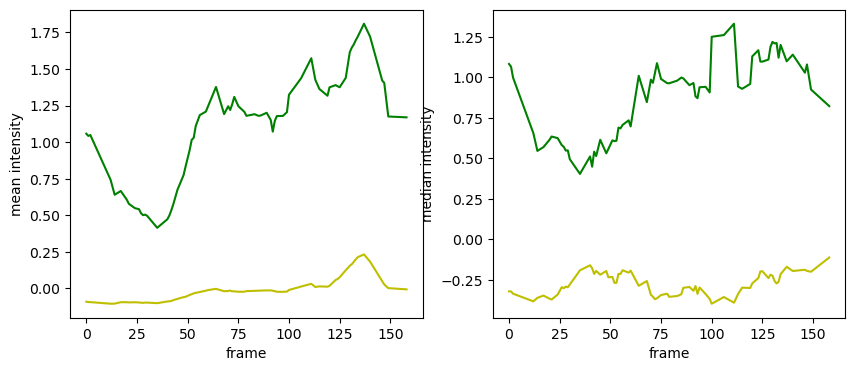

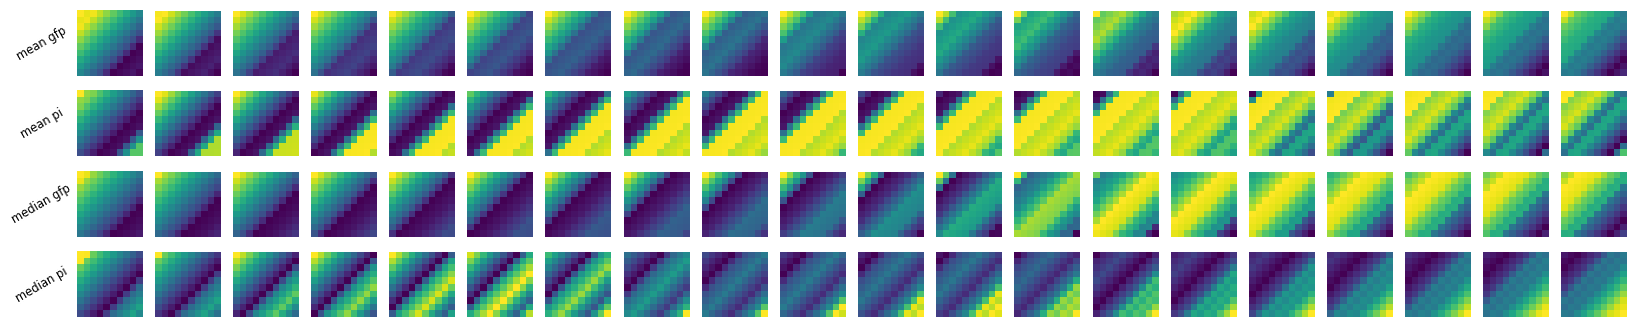

In [97]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
fig2, axs2 = plt.subplots(4,20,figsize=(20,4))
axs[0].set_xlabel("frame")
axs[0].set_ylabel("mean intensity")
axs[1].set_xlabel("frame")
axs[1].set_ylabel("median intensity")

features = ["mean_gfp_norm","mean_pi_norm","median_gfp_norm","median_pi_norm"]
features_disp = ["mean gfp","mean pi","median gfp","median pi"]
W = 10 # sliding window size
S = 1 # stride
R = 10 # steps

Z = []
DISP_TRACK = 1
track_len = []

track_ids = tracks_df['track_id'].unique()
for i, tid in tqdm(enumerate(track_ids),total=len(track_ids)):
    track = tracks_df[tracks_df["track_id"]==tid]

    # interpolation
    for t in range(track["frame"].min(),track["frame"].max()+1):
        if t not in track["frame"]:
            track = pd.concat([track, pd.DataFrame({"frame":[t]})])
    track = track.sort_values(by="frame")
    track = track.drop_duplicates(subset=['frame'], keep='first')

    track[features] = track[features].interpolate(method='linear', axis=0)

    # sliding window
    z = {}
    for f, feature in enumerate(features):
        z[feature] = []

        if i == DISP_TRACK:
            ax2 = axs2[f,0].twinx()
            ax2.yaxis.set_label_position('left')
            ax2.spines['left'].set_position(('axes', -0.45))
            # hide spine and ticks, set group label
            ax2.spines['left'].set_visible(False)
            ax2.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            ax2.spines['bottom'].set_visible(False)
            ax2.set_yticks([])
            ax2.set_ylabel(features_disp[f], rotation=30, size='small',
                    ha='center', va='center')

        for t in range(track["frame"].min(),track["frame"].max()+1-W-R*S,S):
            z_ = sliding_window_matrix(track[feature],W,S,R,t-track["frame"].min())
            z[feature].append(z_)

            if t < 20 and i==DISP_TRACK:
                axs2[f,t].imshow(z_)
                axs2[f,t].set_axis_off()
    
    Z.append(z)
    track_len.append(track["frame"].max()-track["frame"].min()+1-W-R*S) # not work for stride != 1

    if i == DISP_TRACK:
        axs[0].plot(track["frame"],track["mean_gfp_norm"],label="GFP_{}".format(tid),c="g")
        axs[0].plot(track["frame"],track["mean_pi_norm"],label="PI_{}".format(tid),c="y")
        axs[1].plot(track["frame"],track["median_gfp_norm"],label="GFP_{}".format(tid),c="g")
        axs[1].plot(track["frame"],track["median_pi_norm"],label="PI_{}".format(tid),c="y")
        
    if i == 99:
        break

## Feature Embedding with UMAP

In [98]:
Z_flatten = []
label = []
label_t = []
for tid, z in enumerate(Z):
    for t in range(track_len[tid]):            
        for f in features:
            Z_flatten.append(z[f][t].ravel())
            label.append(z[f][t][0,0])
        label_t.append(t)

Z_flatten = np.array(Z_flatten).reshape((-1,4,100))
label = np.array(label).reshape(-1,4)

In [ ]:
# create CNN autoencoder

In [99]:
reducer = umap.UMAP(random_state=42)
reducer.fit(Z_flatten.reshape(-1,4*100))

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [100]:
embedding_all = reducer.transform(Z_flatten.reshape(-1,4*100))

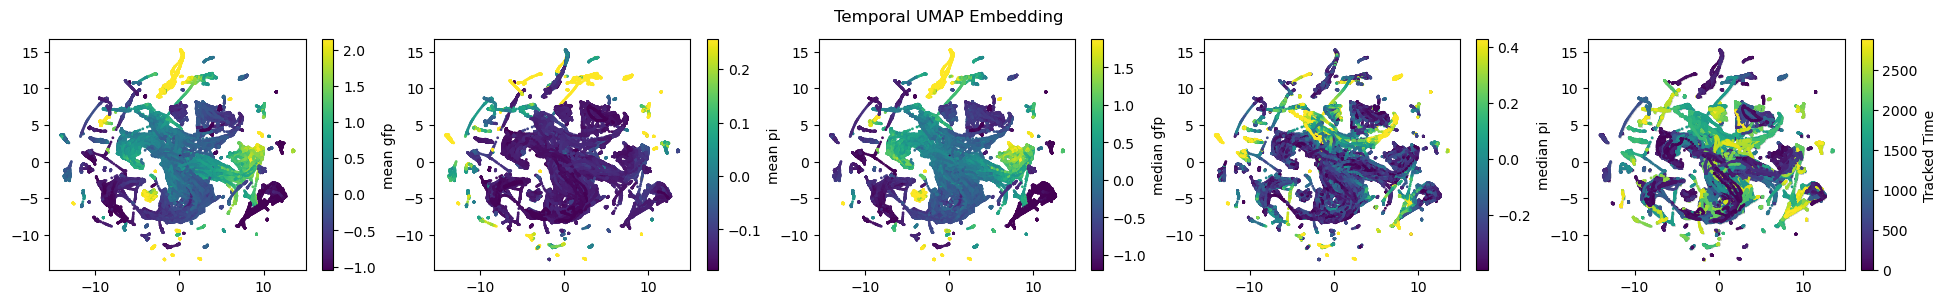

In [101]:
fig, axs = plt.subplots(1,5,figsize=(24,3))
fig.suptitle('Temporal UMAP Embedding')

for i in range(4):
    scatter = axs[i].scatter(embedding_all[:, 0], embedding_all[:, 1],s=1,c=label[:,i], vmin=np.percentile(label[:,i],5), vmax=np.percentile(label[:,i],95))
    cbar = fig.colorbar(scatter, ax=axs[i])
    cbar.set_label(features_disp[i])

axs[4].scatter(embedding_all[:, 0], embedding_all[:, 1],s=1,c="lightgrey")
scatter = axs[4].scatter(embedding_all[:, 0], embedding_all[:, 1],s=1,c=label_t)
cbar = fig.colorbar(scatter, ax=axs[4])
cbar.set_label("Tracked Time")

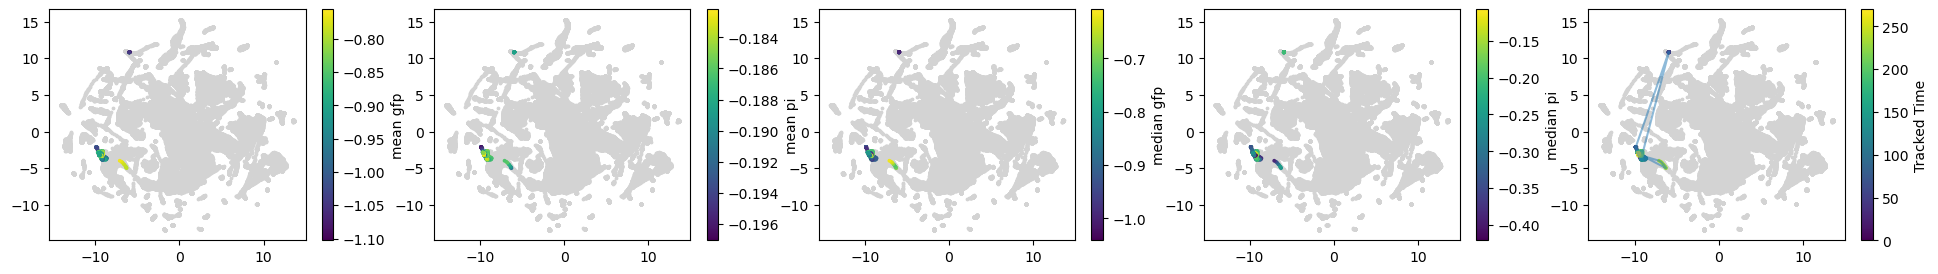

In [109]:
# Embedding with different color coding
fig, axs = plt.subplots(1,5,figsize=(24,3))

INFER_TRACK = 3

# Color track tracking time
z_flatten = Z_flatten[np.sum(track_len[0:INFER_TRACK]):np.sum(track_len[0:INFER_TRACK+1])]
tracked_time = label_t[np.sum(track_len[0:INFER_TRACK]):np.sum(track_len[0:INFER_TRACK+1])]

embedding = reducer.transform(z_flatten.reshape(-1,4*100))

for i in range(4):
    axs[i].scatter(embedding_all[:, 0], embedding_all[:, 1],s=3,c="lightgrey")
    scatter = axs[i].scatter(embedding[:, 0], embedding[:, 1],s=3,c=label[np.sum(track_len[0:INFER_TRACK]):np.sum(track_len[0:INFER_TRACK+1]),i])
    cbar = fig.colorbar(scatter, ax=axs[i])
    cbar.set_label(features_disp[i])

axs[4].scatter(embedding_all[:, 0], embedding_all[:, 1],s=3,c="lightgrey")
axs[4].plot(embedding[:, 0], embedding[:, 1], alpha=0.5)
scatter = axs[4].scatter(embedding[:, 0], embedding[:, 1],s=3,c=tracked_time)
cbar = fig.colorbar(scatter, ax=axs[4])
cbar.set_label('Tracked Time')

(array([1.9753e+04, 1.6326e+04, 1.3240e+04, 1.2205e+04, 1.0981e+04,
        1.0061e+04, 9.3310e+03, 8.4700e+03, 8.1230e+03, 7.5840e+03,
        6.9090e+03, 6.6220e+03, 6.2110e+03, 6.1140e+03, 5.8540e+03,
        5.4070e+03, 4.8500e+03, 4.6020e+03, 4.6070e+03, 4.4640e+03,
        4.1880e+03, 4.2320e+03, 3.7690e+03, 3.5970e+03, 3.2770e+03,
        3.1810e+03, 3.0190e+03, 2.7380e+03, 2.5800e+03, 2.4770e+03,
        2.4240e+03, 2.3790e+03, 2.1750e+03, 2.1240e+03, 1.9400e+03,
        1.8370e+03, 1.6630e+03, 1.6620e+03, 1.5660e+03, 1.4640e+03,
        1.3680e+03, 1.3580e+03, 1.1980e+03, 1.2200e+03, 1.0840e+03,
        9.5500e+02, 8.8200e+02, 8.1400e+02, 7.9200e+02, 6.6900e+02,
        6.9400e+02, 6.4400e+02, 5.9400e+02, 6.1300e+02, 4.9200e+02,
        4.9500e+02, 4.6000e+02, 4.3800e+02, 4.5500e+02, 4.0000e+02,
        3.7800e+02, 3.8900e+02, 3.2700e+02, 3.6700e+02, 3.0800e+02,
        3.2700e+02, 2.8800e+02, 2.9600e+02, 2.9300e+02, 2.6000e+02,
        2.4100e+02, 2.0100e+02, 2.4500e+02, 2.03

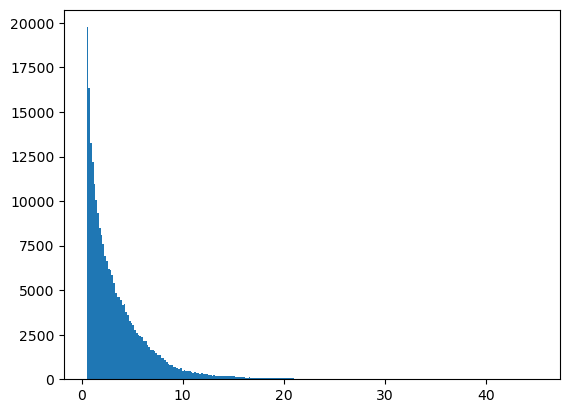

In [108]:
plt.hist(tracks_df[tracks_df["mean_pi_norm"]>0.5]["mean_pi_norm"],bins=256)